In [55]:
import pandas as pd
from sklearn.preprocessing import (
    LabelEncoder,
    StandardScaler,
    OneHotEncoder,
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split


pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [56]:
data = pd.read_parquet("../fastapi_app/data/transaction_fraud_detection.parquet")

In [57]:
def extract_device_info_sklearn(data):
    data = data.copy()
    data_to_join = pd.json_normalize(data["device_info"])
    data = data.drop("device_info", axis = 1)
    data = data.join(data_to_join)
    return data

def extract_timestamp_info_sklearn(data):
    data = data.copy()
    data["timestamp"] = pd.to_datetime(
        data["timestamp"],
        format = 'ISO8601')
    data["year"] = data["timestamp"].dt.year
    data["month"] = data["timestamp"].dt.month
    data["day"] = data["timestamp"].dt.day
    data["hour"] = data["timestamp"].dt.hour
    data["minute"] = data["timestamp"].dt.minute
    data["second"] = data["timestamp"].dt.second
    data = data.drop("timestamp", axis = 1)
    return data

def extract_coordinates_sklearn(data):
    data = data.copy()
    data_to_join = pd.json_normalize(data["location"])
    data = data.drop("location", axis = 1)
    data = data.join(data_to_join)
    return data

def process_data(data):
    data = data.copy()
    data = extract_device_info_sklearn(data)
    data = extract_timestamp_info_sklearn(data)
    X = data.drop('is_fraud', axis = 1)
    y = data['is_fraud']
    numerical_features = [
        "amount",
        "account_age_days",
        "cvv_provided",
        "billing_address_match"
    ]
    binary_features = [
        "cvv_provided",
        "billing_address_match"
    ]
    categorical_features = [
        "currency",
        "merchant_id",
        "payment_method",
        "product_category",
        "transaction_type",
        "browser",
        "os",
        "year",
        "month",
        "day",
        "hour",
        "minute",
        "second",
    ]
    numerical_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(
        handle_unknown = 'ignore',
        sparse_output = False)
    preprocessor = ColumnTransformer(
        transformers = [
            ("numerical", numerical_transformer, numerical_features),
            ("binary", "passthrough", binary_features),
            ("categorical", categorical_transformer, categorical_features),
        ]
    )
    preprocessor.set_output(transform = "pandas") # Output pandas DataFrame
    X = preprocessor.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size = 0.2,       # 20% for testing
        stratify = y,           # Crucial for imbalanced data
        random_state = 42
    )
    return X_train, X_test, y_train, y_test

In [58]:
x_train, x_test, y_train, y_test = process_data(data)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(169841, 391) (42461, 391) (169841,) (42461,)


In [59]:
from xgboost import XGBClassifier

def create_batch_model(**kwargs):
    neg_samples = sum(kwargs["y_train"] == 0)
    pos_samples = sum(kwargs["y_train"] == 1)
    if pos_samples > 0:
        calculated_scale_pos_weight = neg_samples / pos_samples
    else:
        calculated_scale_pos_weight = 1 # Default or handle as error if no positive samples
    model = XGBClassifier(
        objective = 'binary:logistic',  # For binary classification
        eval_metric = 'auc',            # Primary metric to monitor (aligns with River's ROCAUC)
                                        # Consider 'aucpr' (PR AUC) as well, often better for severe imbalance.
        use_label_encoder = False,      # Suppresses a warning with newer XGBoost versions
        random_state = 42,              # For reproducibility
        n_jobs = -1,                    # Use all available CPU cores
        # --- Parameters to TUNE ---
        n_estimators = 200,             # Start: 100-500. Tune with early stopping.
        learning_rate = 0.05,           # Start: 0.01, 0.05, 0.1. Smaller values need more n_estimators.
        max_depth = 5,                  # Start: 3-7. Deeper trees can overfit.
        subsample = 0.8,                # Start: 0.6-0.9.
        colsample_bytree = 0.8,         # Start: 0.6-0.9.
        gamma = 0,                      # Start: 0-0.2. Higher values make the algorithm more conservative.
        # reg_alpha=0,                # Consider tuning if many features (e.g., 0, 0.01, 0.1, 1)
        # reg_lambda=1,               # Consider tuning (e.g., 0.1, 1, 10)
        # --- CRITICAL for Imbalance ---
        scale_pos_weight = calculated_scale_pos_weight # Use your calculated value here!
    )
    return model

In [60]:
model = create_batch_model(
    y_train = y_train
)

In [61]:
from yellowbrick.classifier import ClassificationReport

classes = list(set(y_train.unique().tolist() + y_test.unique().tolist()))
classes.sort()
visualizer = ClassificationReport(
    model,
    classes = classes,
    support = True,
    n_jobs = -1
)

/home/rafaelcoelho/Workbench/COELHORealTime/tests/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:40:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


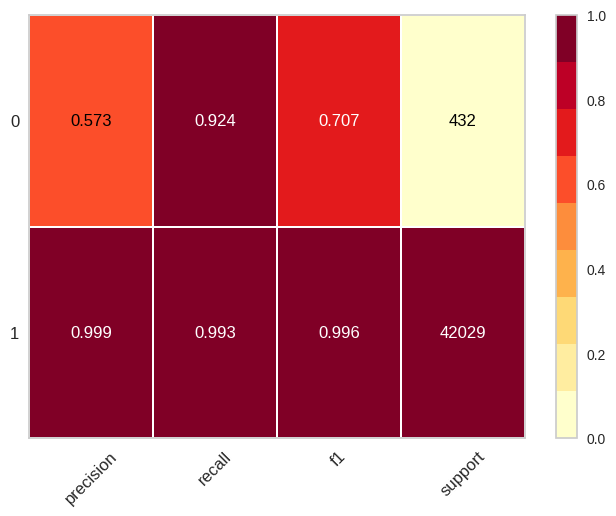

In [62]:
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
#visualizer.show()
visualizer.fig.savefig("visualizer.png")

In [63]:
dir(visualizer)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__sklearn_tags__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_ax',
 '_build_request_for_signature',
 '_check_feature_names',
 '_check_n_features',
 '_decode_labels',
 '_displayed_scores',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_fig',
 '_get_default_requests',
 '_get_doc_link',
 '_get_metadata_request',
 '_get_param_names',
 '_get_tags',
 '_labels',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_size',
 '_validate_data',
 '_validate_params',
 '_wrapped',
 'ax',
 'class_colors_',
 'class_counts_',
 'classes',
 'classes_',

In [64]:
visualizer.fig.savefig("visualizer.png")

In [65]:
y_pred = visualizer.predict(x_test)

In [66]:
from sklearn.metrics import accuracy_score

In [67]:
dir(visualizer)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__sklearn_tags__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_ax',
 '_build_request_for_signature',
 '_check_feature_names',
 '_check_n_features',
 '_decode_labels',
 '_displayed_scores',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_fig',
 '_get_default_requests',
 '_get_doc_link',
 '_get_metadata_request',
 '_get_param_names',
 '_get_tags',
 '_labels',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_size',
 '_validate_data',
 '_validate_params',
 '_wrapped',
 'ax',
 'class_colors_',
 'class_counts_',
 'classes',
 'classes_',

In [68]:
visualizer.estimator

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=-1, num_parallel_tree=None, ...)